In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d
import scipy.io as io
np.random.seed(7)
torch.manual_seed(7)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available() == True:
    dtype = torch.cuda.FloatTensor
    dtype_long = torch.cuda.LongTensor
else:
    dtype = torch.FloatTensor
    dtype_long = torch.LongTensor
    
torch.set_default_tensor_type(dtype)

In [4]:
features = ['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', \
            'FAQ','RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'ICV', 'Ventricles', 'DX']
descriptors = ['RID','Month_bl']

features_eff = features + descriptors + ['EXAMDATE']

In [5]:
def Diagnosis_conv(value):
    #Convert diagnosis from str to float
    if value == 'CN':
        return 0.
    if value == 'MCI':
        return 1.
    if value == 'AD':
        return 2.
    return float('NaN')


def DX_conv(value):
    #Convert diagnosis change from str to float
    if isinstance(value, str):
        if value.endswith('Dementia'):
            return 2.
        if value.endswith('MCI'):
            return 1.
        if value.endswith('NL'):
            return 0.

    return float('NaN')

def str2date(string):
    #Convert str to datetime object 
    return datetime.strptime(string, '%m/%d/%y')

# If there are features with non-numeric values, convert them to numerical values
CONVERTERS = {
    'CognitiveAssessmentDate': str2date,
    'ScanDate': str2date,
    'Forecast Date': str2date,
    'EXAMDATE': str2date,
    'Diagnosis': Diagnosis_conv,
    'DX': DX_conv,
    'DX_bl' : Diagnosis_conv
}

In [6]:
csv_path = '/content/drive/My Drive/bmin521/TADPOLE_D1_D2.csv'
data = pd.read_csv(csv_path, converters=CONVERTERS)
data = data[features_eff]

In [7]:
defaults = {}
stddevs = {}
for f in features:
    vec = data[f]
    vec = vec[np.logical_not(np.isnan(vec))]
    defaults[f] = np.average(vec)
    stddevs[f] = np.std(vec)

In [8]:
print(defaults)
print(stddevs)

{'Hippocampus': 6681.723757718318, 'WholeBrain': 1011816.2657042529, 'Entorhinal': 3444.7188127995055, 'MidTemp': 19203.2603184418, 'CDRSB': 2.171426977574473, 'ADAS11': 11.394676767676769, 'ADAS13': 17.513888259292838, 'MMSE': 26.592252575011194, 'FAQ': 5.593062041360907, 'RAVLT_immediate': 34.480353300871926, 'RAVLT_learning': 4.025025478428264, 'RAVLT_forgetting': 4.233844406587166, 'ICV': 1534110.7214741604, 'Ventricles': 42147.086769644055, 'DX': 0.9283468104222821}
{'Hippocampus': 1239.8611789261104, 'WholeBrain': 111953.35659350622, 'Entorhinal': 811.7092204950306, 'MidTemp': 3137.912561466727, 'CDRSB': 2.80995251591356, 'ADAS11': 8.6322547681062, 'ADAS13': 11.69690529415005, 'MMSE': 3.9482629221972667, 'FAQ': 7.920388615650043, 'RAVLT_immediate': 13.610872200834704, 'RAVLT_learning': 2.8148117016161254, 'RAVLT_forgetting': 2.526082326702057, 'ICV': 166269.78186514266, 'Ventricles': 23269.89780763909, 'DX': 0.7347036479102834}


In [9]:
data.describe()

,Hippocampus,WholeBrain,Entorhinal,MidTemp,CDRSB,ADAS11,ADAS13,MMSE,FAQ,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,ICV,Ventricles,DX,RID,Month_bl
count,6802.000000,7.689000e+03,6469.000000,6469.000000,8963.000000,8910.000000,8824.000000,8932.000000,8994.000000,8831.000000,8831.000000,8805.000000,7.953000e+03,7445.000000,8904.000000,12741.000000,12741.000000
mean,6681.723758,1.011816e+06,3444.718813,19203.260318,2.171427,11.394677,17.513888,26.592253,5.593062,34.480353,4.025025,4.233844,1.534111e+06,42147.086770,0.928347,2240.325720,26.126760
std,1239.952328,1.119606e+05,811.771966,3138.155124,2.810109,8.632739,11.697568,3.948484,7.920829,13.611643,2.814971,2.526226,1.662802e+05,23271.460752,0.734745,1855.269911,26.194216
min,2219.000000,6.490910e+05,1041.000000,8044.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,-12.000000,2.918840e+02,5650.000000,0.000000,2.000000,0.000000
25%,5830.000000,9.337950e+05,2905.000000,17183.000000,0.000000,5.330000,9.000000,25.000000,0.000000,25.000000,2.000000,3.000000,1.417170e+06,25127.000000,0.000000,618.000000,5.967210
50%,6759.500000,1.009330e+06,3482.000000,19240.000000,1.000000,9.000000,15.000000,28.000000,1.000000,33.000000,4.000000,4.000000,1.522370e+06,37434.000000,1.000000,1280.000000,18.163900
75%,7583.000000,1.088250e+06,4013.000000,21397.000000,3.000000,15.000000,24.000000,29.000000,9.000000,44.000000,6.000000,6.000000,1.641200e+06,53433.000000,1.000000,4328.000000,36.295100
max,11207.000000,1.486040e+06,6711.000000,32189.000000,18.000000,70.000000,85.000000,30.000000,30.000000,75.000000,14.000000,15.000000,2.110290e+06,162729.000000,2.000000,5296.000000,128.754000


In [10]:
def has_data_mask(frame):
    return ~frame.isnull().apply(np.all, axis=1)

def get_data_dict(frame, features):
    ret = {}
    frame_ = frame.copy()
    frame_['Month_bl'] = frame_['Month_bl'].round().astype(int)
    for subj in np.unique(frame_.RID):
        subj_data = frame_[frame_.RID == subj].sort_values('Month_bl')
        subj_data = subj_data[has_data_mask(subj_data[features])]

        subj_data = subj_data.set_index('Month_bl', drop=True)
        ret[subj] = subj_data.drop(['RID'], axis=1)
    return ret

In [11]:
data_ = get_data_dict(data,features)

In [12]:
def valid(time_array, tmax, tmin):
    return time_array[(time_array >= tmin) & (time_array <= tmax)]

# In order to impute missing data at the first time points for each subject, population averages are used
# At other time points where there is missing data, linear interpolation is used to fill these timepoints
def impute_data(month_true, val_true, val_default, month_interp, f):
    has_data = ~np.isnan(val_true)
    valid_x, valid_y = month_true[has_data], val_true[has_data]
    interp = np.full(month_interp.shape, np.nan, np.float)
    truth = np.full(month_interp.shape, np.nan)
    
    for i in range(month_true.shape[0]):
        month = month_true[i]
        interp[month] = val_true[i]
        truth[month] = val_true[i]
        
    # fill first timepoint
    interp[0] = valid_y[0] if sum(has_data) else val_default
    
    if len(valid_y) == 1:
        # will be different from previous line when valid_x is not the first tp
        interp[np.in1d(month_interp, valid_x[0])] = valid_y[0]
    elif len(valid_y) > 1:
        interp_fn = interp1d(valid_x, valid_y, kind='linear')
        timepoints = valid(month_interp, valid_x[-1],
                           valid_x[0]).astype(np.int)
        interp[np.in1d(month_interp, timepoints)] = interp_fn(timepoints)
        
    for j in range(month_interp.shape[0]):
        if np.isnan(interp[j]):
            interp[j] = val_default
            
        if f == 'DX':
            interp[j] = np.round(interp[j])
        else:
            interp[j] = (interp[j] - defaults[f])/stddevs[f]
    
    mask = np.in1d(month_interp, month_true[has_data].astype(np.int))

    return interp, mask, truth

data_dict = dict()
fields = ['Month_bl'] + features
for rid, sframe in data_.items():
    xin = sframe.index.values
    xin = xin - xin[0]
    xout = np.arange(xin[-1] - xin[0] + 1)
    in_seqs = {'Month_bl': xout}
    mk_seqs = {'Month_bl': np.zeros(len(xout), dtype=bool)}
    th_seqs = {'Month_bl': np.full(len(xout), np.nan)}
    for f in features:
        yin = sframe[f].values
        in_seqs[f], mk_seqs[f], th_seqs[f] = impute_data(xin, yin, defaults[f], xout, f)
    data_dict[rid] = {'input': np.array([in_seqs[f] for f in fields]).T}
    data_dict[rid]['mask'] = np.array([mk_seqs[f] for f in fields]).T
    data_dict[rid]['truth'] = np.array([th_seqs[f] for f in fields]).T

    assert data_dict[rid]['input'].shape == data_dict[rid]['mask'].shape == data_dict[rid]['truth'].shape


/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/usr/local/lib/python3.6/dist-packages/scipy/interpolate/interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [13]:
class rnn(nn.Module):
    def __init__(self, data_dict, input_size, output_size, hidden_size, sigma_u, sigma_f, lr):
        super(rnn, self).__init__()
        self.data_dict = data_dict
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sigma_f = sigma_f
        self.sigma_u = sigma_u
        
        self.get_train_rid()
        self.initialize_parameters()
        
        self.lossfn_class = nn.CrossEntropyLoss(reduction='mean')
        self.lossfn_reg = nn.L1Loss(reduction='mean')
        self.softmax = nn.Softmax(dim=1)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr) 
        self.training_loss = []

    def fwd_pass(self, X):
        ntimepts = X.shape[0]
        nfeat = X.shape[1]
        y = torch.zeros(ntimepts, self.output_size)
        y[0,0:nfeat-1] = X[0,0:nfeat-1].clone()
        y[0,nfeat-1+int(X[0,nfeat-1].clone())] = 1.
        h = torch.zeros(1, self.hidden_size)
        for i in range(ntimepts-1):
            x1 = torch.zeros(1,self.output_size-3)
            x2 = torch.zeros(1,3)
            x1[0,0:nfeat-1] = X[i,0:nfeat-1].clone()
            x2[0,int(X[i,nfeat-1].clone())] = 1. 
            xin = torch.cat((x1,x2), dim = 1).clone()
            u = self.sigma_u(torch.matmul(xin,self.wx))
            f = self.sigma_f(torch.matmul(h,self.wh) + torch.matmul(u, self.wu))
            h = f*h + (1-f)*u
            yr = torch.matmul(h,self.wr) + xin[0,0:nfeat-1].clone()
            yc = self.softmax(torch.matmul(h, self.wc))
            y[i+1,:] = torch.cat((yr, yc), dim = 1).clone()
        return y
        
    def get_train_rid(self):
        rids = []
        for rid, sframe in self.data_dict.items():
            rids.append(rid)
        random.shuffle(rids)
        nsubj = len(rids)
        self.rids_train = rids[:int(0.8 * nsubj)]
        self.rids_test = rids[int(0.8 * nsubj):]
        
        
    def initialize_parameters(self):    
        self.wh = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.wx = nn.Parameter(torch.Tensor(self.input_size, self.hidden_size))
        self.wu = nn.Parameter(torch.Tensor(self.hidden_size, self.hidden_size))
        self.wr = nn.Parameter(torch.Tensor(self.hidden_size, self.output_size-3))
        self.wc = nn.Parameter(torch.Tensor(self.hidden_size, 3))
        nn.init.xavier_uniform_(self.wh)
        nn.init.xavier_uniform_(self.wx)
        nn.init.xavier_uniform_(self.wu)
        nn.init.xavier_uniform_(self.wr)
        nn.init.xavier_uniform_(self.wc)

    def save_parameters(self, path):
        io.savemat(path, {'wh':self.wh.cpu().data.numpy(), 'wx':self.wx.cpu().data.numpy(), 'wu':self.wu.cpu().data.numpy(),\
                          'wr':self.wr.cpu().data.numpy(), 'wc':self.wc.cpu().data.numpy()})   
        
    def load_parameters(self, path):
        params = io.loadmat(path)
        self.wh = nn.Parameter(torch.from_numpy(params['wh']).type(dtype))
        self.wx = nn.Parameter(torch.from_numpy(params['wx']).type(dtype))
        self.wu = nn.Parameter(torch.from_numpy(params['wu']).type(dtype))
        self.wr = nn.Parameter(torch.from_numpy(params['wr']).type(dtype)) 
        self.wc = nn.Parameter(torch.from_numpy(params['wc']).type(dtype)) 

    def modify_lr(self, lr):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr) 
    
    def predict(self, X, startpt, endpt):
        nfeat = X.shape[1]
        xin = torch.zeros(1, self.output_size)
        y = torch.zeros(1, self.output_size)
        y[0,0:nfeat-1] = X[0,0:nfeat-1]
        y[0,nfeat-1+int(X[0,nfeat-1])] = 1.
        h = torch.zeros(1, self.hidden_size)
        for i in range(startpt, endpt):
            if i >= (endpt - startpt)/2:
                xin = y
            else:
                x1 = torch.zeros(1,self.output_size-3)
                x2 = torch.zeros(1,3)
                x1[0,0:nfeat-1] = X[i,0:nfeat-1]
                x2[0,int(X[i,nfeat-1])] = 1. 
                xin = torch.cat((x1,x2), dim = 1)
            u = self.sigma_u(torch.matmul(y,self.wx))
            f = self.sigma_f(torch.matmul(h,self.wh) + torch.matmul(u, self.wu))
            h = f*h + (1-f)*u
            yr = torch.matmul(h,self.wr) + xin[0,0:nfeat-1]
            yc = self.softmax(torch.matmul(h, self.wc))
            y = torch.cat((yr, yc), dim = 1)

        _,yclass = torch.max(y[0,nfeat-1:],0)
        yclass = yclass.cpu().data.numpy()
        yreg = y[0,0:nfeat-1].cpu().data.numpy()
        return (yclass, yreg, y[0,nfeat-1:].cpu().data.numpy())

    def predict_test(self, X, startpt, endpt):
        nfeat = X.shape[1]
        xin = torch.zeros(1, self.output_size)
        y = torch.zeros(1, self.output_size)
        y[0,0:nfeat-1] = X[0,0:nfeat-1]
        y[0,nfeat-1+int(X[0,nfeat-1])] = 1.
        h = torch.zeros(1, self.hidden_size)
        for i in range(endpt):
            if i >= startpt:
                xin = y
            else:
                x1 = torch.zeros(1,self.output_size-3)
                x2 = torch.zeros(1,3)
                x1[0,0:nfeat-1] = X[i,0:nfeat-1]
                x2[0,int(X[i,nfeat-1])] = 1. 
                xin = torch.cat((x1,x2), dim = 1)
            u = self.sigma_u(torch.matmul(xin,self.wx))
            f = self.sigma_f(torch.matmul(h,self.wh) + torch.matmul(u, self.wu))
            h = f*h + (1-f)*u
            yr = torch.matmul(h,self.wr)+ xin[0,0:nfeat-1]
            yc = self.softmax(torch.matmul(h, self.wc))
            y = torch.cat((yr, yc), dim = 1)
            
        _,yclass = torch.max(y[0,nfeat-1:],0)
        yclass = yclass.cpu().data.numpy()
        yreg = y[0,0:nfeat-1].cpu().data.numpy()
        return (yclass, yreg, y[0,nfeat-1:].cpu().data.numpy())
    
    def compute_loss(self, X, Y, boolmask_class, boolmask_reg):
        nfeat = X.shape[1]
        Ypred = self.fwd_pass(X)
        Y_class = Y[:,nfeat-1].type(dtype_long)
        Ypred_class = Ypred[:,nfeat-1:self.output_size]
        Y_reg = Y[:,0:nfeat-1]
        Ypred_reg = Ypred[:,0:nfeat-1]
        
        class_loss = self.lossfn_class(Ypred_class, Y_class)
        reg_loss = self.lossfn_reg(Ypred_reg, Y_reg)
        loss = class_loss + reg_loss
        return loss

    def model_train_fb(self, nepochs):
        lr_modif = False
        for epoch in range(nepochs):
            netloss = 0.
            self.optimizer.zero_grad()
            for rid in self.rids_train:
                Y_ = self.data_dict[rid]['input']
                X = torch.from_numpy(Y_).type(dtype)
                Y = torch.from_numpy(Y_).type(dtype)
                boolmask_reg = self.data_dict[rid]['mask'][:,1:X.shape[1]-1]
                boolmask_class = self.data_dict[rid]['mask'][:,X.shape[1]-1]
                loss = self.compute_loss(X[:,1:],Y[:,1:],boolmask_class, boolmask_reg)
                netloss = netloss + loss
            netloss = netloss / len(self.rids_train)
            netloss.backward()
            self.optimizer.step()
            self.training_loss.append(netloss.cpu().data.numpy())
            print('Loss at epoch', epoch,':',netloss.cpu().data.numpy())
                
    def model_test_d1d2(self):
        yclass_true = []
        yreg_true = []
        yclass_pred = []
        yreg_pred = []
        yclass_probs = []
        for rid in self.rids_test:
            Y_ = self.data_dict[rid]['input']
            starttimept = int(Y_[0][0])
            X = torch.from_numpy(Y_[:,1:]).type(dtype)
            endtimept = int(Y_[Y_.shape[0]-1][0])

            for timept in range(starttimept, endtimept):
              yclass, yreg, classprobs = self.predict(X, starttimept, timept+1)
              classtrue = Y_[timept][Y_.shape[1]-1]
              regtrue = Y_[timept][Y_.shape[1]-2]*stddevs['Ventricles'] + defaults['Ventricles']
              regtrue = regtrue / (Y_[timept][Y_.shape[1]-3]*stddevs['ICV'] + defaults['ICV'])

              if self.data_dict[rid]['mask'][timept][Y_.shape[1]-1]:
                yclass_true.append(classtrue)
                yclass_pred.append(yclass)
                yclass_probs.append(classprobs)

              if self.data_dict[rid]['mask'][timept][Y_.shape[1]-2] and self.data_dict[rid]['mask'][timept][Y_.shape[1]-3]:
                yreg_true.append(regtrue)
                regpred = yreg[Y_.shape[1]-3]*stddevs['Ventricles'] + defaults['Ventricles']
                regpred = regpred / (yreg[Y_.shape[1]-4]*stddevs['ICV'] + defaults['ICV'])
                yreg_pred.append(regpred)
        return yclass_true, yreg_true, yclass_pred, yreg_pred, yclass_probs

    def model_test_d4(self, testdata, data_):
        def month_between(end, start):
            diff = relativedelta(end, start)
            months = 12 * diff.years + diff.months
            to_next = relativedelta(end + relativedelta(months=1, days=-diff.days),
                            end).days
            to_prev = diff.days
            return months + (to_next < to_prev)
        yclass_true = []
        yreg_true = []
        yclass_pred = []
        yreg_pred = []
        yclass_probs = []

        count = 0
        for rid in testdata['RID']:
            Y_ = self.data_dict[rid]['input']
            X = torch.from_numpy(Y_[:,1:]).type(dtype)
            if rid == 4960: # Duplicate entry 
                startdate = data_[rid]['EXAMDATE'][0]
                starttime = int(Y_[0][0])
            else:
                startdate = data_[rid]['EXAMDATE'][int(Y_[Y_.shape[0]-1][0])]
                starttime = int(Y_[Y_.shape[0]-1][0])
            enddate = testdata['CognitiveAssessmentDate'][count]
            endtime = starttime + month_between(enddate,startdate)
            classtrue = testdata['Diagnosis'][count] 
            regtrue = testdata['Ventricles'][count]
            yclass, yreg, classprobs = self.predict_test(X, starttime, endtime)
            count = count + 1
            if not (np.isnan(classtrue)):
                yclass_true.append(classtrue)
                yclass_pred.append(yclass)
                yclass_probs.append(classprobs)
            if not (np.isnan(regtrue)):
                yreg_true.append(regtrue)
                regpred = yreg[Y_.shape[1]-3]*stddevs['Ventricles'] + defaults['Ventricles']
                regpred = regpred / (yreg[Y_.shape[1]-4]*stddevs['ICV'] + defaults['ICV'])
                yreg_pred.append(regpred)

        return yclass_true, yreg_true, yclass_pred, yreg_pred, yclass_probs

In [14]:
nclasses = 3
input_size = len(features) + nclasses - 1
output_size = len(features) + nclasses - 1
hidden_size = 200
lr = 0.01
activation_u = torch.tanh
activation_f = torch.tanh
net = rnn(data_dict, input_size, output_size, hidden_size, activation_u, activation_f, lr)

In [ ]:
net.model_train_fb(200)
save_path = '/content/drive/My Drive/bmin521/model_params.mat'
net.save_parameters(save_path)

Loss at epoch 0 : 0.5905715
Loss at epoch 1 : 0.5907928
Loss at epoch 2 : 0.5905669
Loss at epoch 3 : 0.59048676
Loss at epoch 4 : 0.5905774
Loss at epoch 5 : 0.5905544
Loss at epoch 6 : 0.5904662
Loss at epoch 7 : 0.5904443
Loss at epoch 8 : 0.5904825
Loss at epoch 9 : 0.5904882
Loss at epoch 10 : 0.5904458
Loss at epoch 11 : 0.59041137
Loss at epoch 12 : 0.59041524
Loss at epoch 13 : 0.5904299
Loss at epoch 14 : 0.5904197
Loss at epoch 15 : 0.5903937
Loss at epoch 16 : 0.59037834
Loss at epoch 17 : 0.5903812
Loss at epoch 18 : 0.5903844
Loss at epoch 19 : 0.5903739
Loss at epoch 20 : 0.5903565
Loss at epoch 21 : 0.5903478
Loss at epoch 22 : 0.5903481
Loss at epoch 23 : 0.5903465
Loss at epoch 24 : 0.5903358
Loss at epoch 25 : 0.5903243
Loss at epoch 26 : 0.5903196
Loss at epoch 27 : 0.5903182
Loss at epoch 28 : 0.5903118
Loss at epoch 29 : 0.5903023
Loss at epoch 30 : 0.5902945
Loss at epoch 31 : 0.59029126
Loss at epoch 32 : 0.590287
Loss at epoch 33 : 0.5902801
Loss at epoch 34 : 0

In [ ]:
net.optimizer = torch.optim.Adam(net.parameters(), lr=0.0001) 

In [16]:
load_path = '/content/drive/My Drive/bmin521/model_params.mat'
net.load_parameters(load_path)

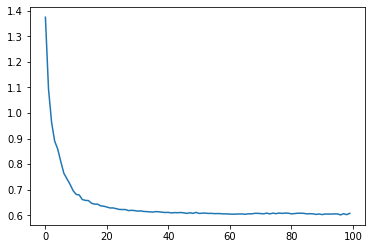

In [ ]:
plt.plot(net.training_loss)
plt.show()

In [17]:
yclass_true, yreg_true, yclass_pred, yreg_pred, yclass_probs= net.model_test_d1d2()

In [18]:
count = 0
for i in range(len(yclass_true)):
    if int(yclass_true[i]) == int(yclass_pred[i]):
        count = count + 1
print(float(count)/len(yclass_true))

0.8666219839142091


In [19]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(yclass_true, yclass_pred))

0.8267024192897785


In [20]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(yreg_true, yreg_pred))

0.0012511045086074756


In [21]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(yclass_true, yclass_probs, multi_class='ovr'))

0.9341564643881234


In [22]:
# Longitudinal prediction set: Data set D4
def str2date_d4(string):
    #Convert str to datetime object """
    return datetime.strptime(string, '%Y-%m-%d')

# If there are features with non-numeric values, convert them to numerical values
CONVERTERS_D4 = {
    'CognitiveAssessmentDate': str2date_d4,
    'ScanDate': str2date_d4,
    'Forecast Date': str2date_d4,
    'EXAMDATE': str2date_d4,
    'Diagnosis': Diagnosis_conv,
    'DX': DX_conv,
    'DX_bl' : Diagnosis_conv
}

csv_path = '/content/drive/My Drive/bmin521/TADPOLE_D4_corr.csv'
d4 = pd.read_csv(csv_path, converters=CONVERTERS_D4)
feat_d4 = ['RID','CognitiveAssessmentDate','Ventricles','Diagnosis']
d4 = d4[feat_d4]
d4.describe()

,RID,Ventricles,Diagnosis
count,234.000000,150.000000,210.000000
mean,3373.170940,0.029805,0.742857
std,1747.349619,0.013205,0.705801
min,21.000000,0.006354,0.000000
25%,2124.750000,0.019420,0.000000
50%,4231.500000,0.028260,1.000000
75%,4737.250000,0.034968,1.000000
max,5296.000000,0.065312,2.000000


In [23]:
yclass_true, yreg_true, yclass_pred, yreg_pred, yclass_probs = net.model_test_d4(d4, data_)

In [24]:
count = 0
for i in range(len(yclass_true)):
    if int(yclass_true[i]) == int(yclass_pred[i]):
        count = count + 1
print(float(count)/len(yclass_true))

0.7619047619047619


In [25]:
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(yclass_true, yclass_pred))

0.7061004381530166


In [26]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(yclass_true, yclass_probs, multi_class='ovr'))

0.7876960577198111


In [27]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(yreg_true, yreg_pred))

0.010474172073489782
